# Plotting Positions of Galaxy Cluster Members in Extragalactic Catalogs

In this example script we show how to select for and look at members of individual clusters.

Owners: **Dan Korytov [@dkorytov](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@dkorytov)**, **Patricia Larsen**

Last verified run: **March 8, 2024** by @patricialarsen

This notebook demonstrates how to access the extra galactic catalog through the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) as well as how filter on galaxy features and cluster membership.

__Objectives__:

After working through and studying this Notebook you should be able to

1. Access extragalactic catalogs (cosmoDC2, skysim, romanrubin) through the GCR.
2. Select galaxy cluster centrals as a proxy for clusters.
3. Select galaxies in individual clusters by using the host_id quantity.
4. Plotting galaxy clustermembers positions on the sky as well as their comoving position in space.


__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC

In [2]:
import GCRCatalogs
import numpy as np
from astropy.table import Table
from GCR import GCRQuery
import matplotlib.pyplot as plt
%matplotlib inline

### Reading catalog
We load in the catalog with the "load_catalog" command, and then the values with the "get_quantities" command using filters to select sub-samples of the catalog.  

### Help for error messages:
If this fails to find the appropriate quantities, check that the desc-python kernel is being used and if this is not available source the kernels by running the following command on a terminal at nersc: "source 
/global/common/software/lsst/common/miniconda/kernels/setup.sh"

We are loading in a smaller version of the full cosmoDC2 catalog - this contains the same information as the full catalog but with a smaller sky area.

In [ ]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

### Other catalog options:
Some alternate catalogs that you might want to look at include skysim, which is a 5000 square degree extragalactic catalog, and the Roman Rubin catalog which is a smaller extragalactic catalog and image simulation. To load these instead execute one of the two cells below.


In [14]:
gc = GCRCatalogs.load_catalog('skysim5000_v1.1.2_small')

In [13]:
gc = GCRCatalogs.load_catalog('roman_rubin_2023_v1.1.3_elais')

In [15]:
galaxy_data = gc.get_quantities(['ra', 'dec', 'mag_r', 'halo_id'], filters=['mag_r < 19'])
cluster_data = gc.get_quantities(['ra','dec', 'halo_mass', 'halo_id'], 
                                 filters=['is_central', 'halo_mass > 1e14', 'redshift < 0.2'])

### Plot individual clusters
The cluster_data we loaded selects for central galaxies in clusters of mass higher than 10^14 solar masses/h below redshift 0.2. We will plot three such clusters in the skysim region. 

For each of these clusters we can match the galaxies by selecting on 'halo_id' and make a scatter plot of the projected positions around the central galaxy. Note that the size of the circles corresponds to the r-band magnitude of the galaxies. 

The cluster data is cast into a familiar astropy table.

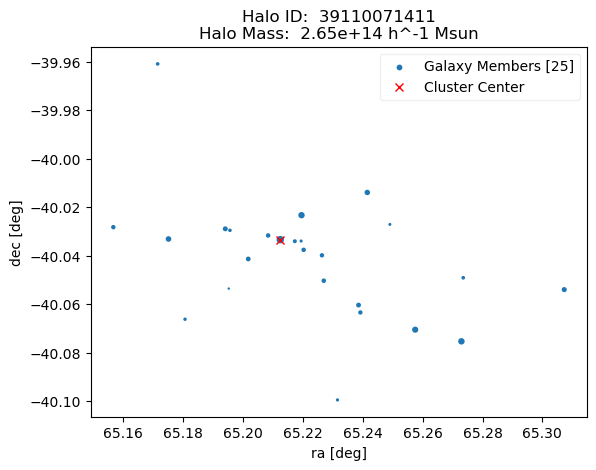

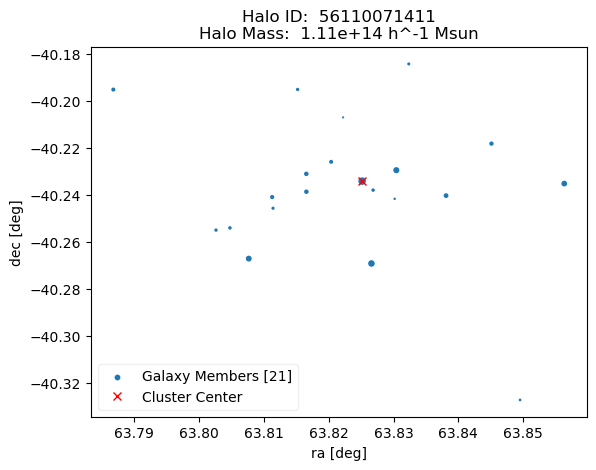

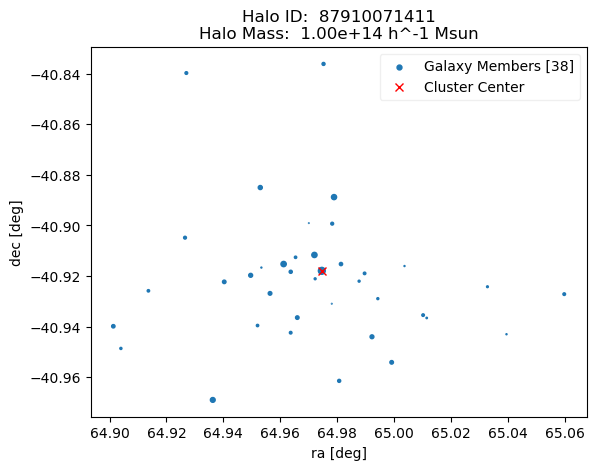

In [16]:
cluster_data = Table(cluster_data)
for i, cluster in enumerate(cluster_data):
    if (i >= 3):
        break # plot only the first 3
    members = GCRQuery('halo_id == {}'.format(cluster['halo_id'])).filter(galaxy_data)
    plt.figure()
    plt.scatter(
        members['ra'], 
        members['dec'], 
        s=(19-members['mag_r'])*8, 
        label='Galaxy Members [{}]'.format(len(members['ra']))
    )
    plt.plot(cluster['ra'], cluster['dec'], 'xr', label='Cluster Center')
    plt.legend(loc='best', framealpha=0.3)
    plt.xlabel(r'ra [deg]')
    plt.ylabel(r'dec [deg]')
    plt.title('Halo ID:  {}\nHalo Mass:  {:.2e} h^-1 Msun'.format(cluster['halo_id'], cluster['halo_mass']))
        
plt.show()

### Extensions:
We can load further information on the cluster members. For instance the second cluster looks a little odd in projected space, so we re-make these plots in comoving cartesian coordinates x and y in the example below. We also map the colours to the x-direction velocities. 

To do this you need to load the required quantities from the catalog before using them. A simple way to double check the quantity names is the command "gc.list_all_quantities()".

In [17]:
galaxy_data = gc.get_quantities(['ra', 'dec', 'mag_r', 'halo_id', 'position_x', 'position_y', 'velocity_x', 'velocity_y'], filters=['mag_r < 19'])
cluster_data = gc.get_quantities(['ra','dec', 'halo_mass', 'halo_id', 'position_x', 'position_y'], 
                                 filters=['is_central', 'halo_mass > 1e14', 'redshift < 0.2'])

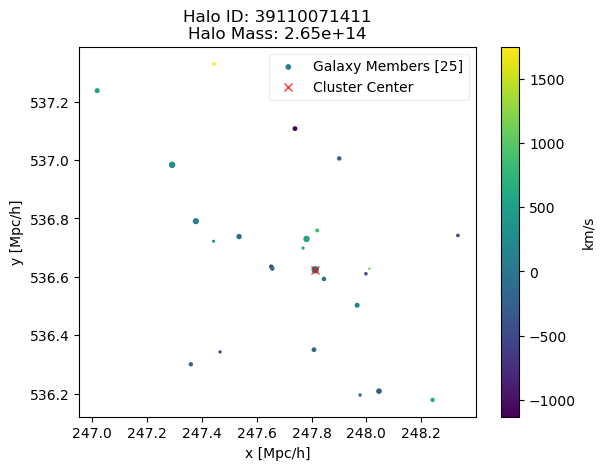

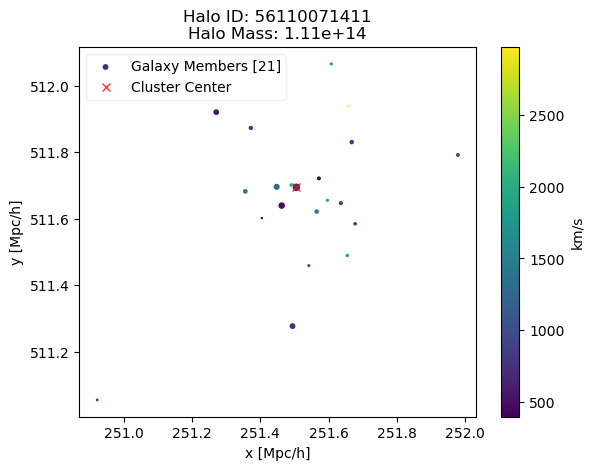

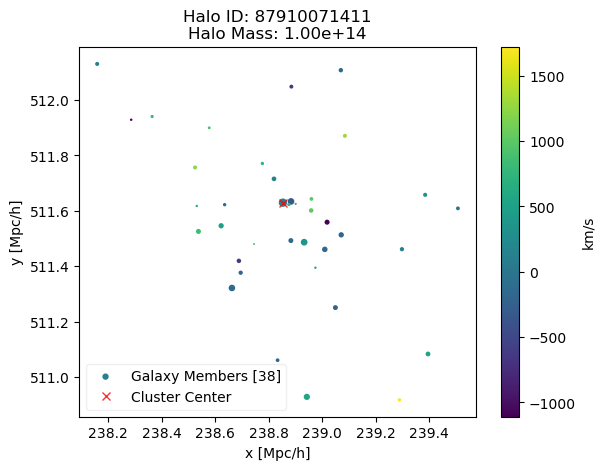

In [18]:
cluster_data = Table(cluster_data)
for i, cluster in enumerate(cluster_data):
    if (i >= 3):
        break # plot only the first 3
    members = GCRQuery('halo_id == {}'.format(cluster['halo_id'])).filter(galaxy_data)
    plt.figure()
    plt.scatter(
        members['position_x'],
        members['position_y'],
        s=(19-members['mag_r'])*8, 
        label='Galaxy Members [{}]'.format(len(members['ra'])),
        c=members['velocity_x'],
        cmap='viridis')
    plt.plot(cluster['position_x'], cluster['position_y'],'xr',label='Cluster Center', alpha=0.8)
    plt.legend(loc='best',framealpha=0.3)
    plt.xlabel(r'x [Mpc/h]')
    plt.ylabel(r'y [Mpc/h]')
    plt.title('Halo ID: {}\nHalo Mass: {:.2e}'.format(cluster['halo_id'], cluster['halo_mass']))
    plt.colorbar(label='km/s')
plt.show()